In [40]:
from langgraph.graph import START, END, StateGraph
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
import os
from dotenv import load_dotenv
from typing import Literal, TypedDict
load_dotenv()


# Generate LinkedIn Post with evaluator-optimizer(iterative)workflow

True

In [41]:
# Models

repo_id = "meta-llama/Llama-3.1-8B-Instruct"
    # repo_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
generator_llm = HuggingFaceEndpoint(
    repo_id= repo_id,
    max_new_tokens= 100,
    temperature= 0.6,
    huggingfacehub_api_token= os.getenv("HUGGINGFACEHUB_API_TOKEN")
)
evaluator_llm = HuggingFaceEndpoint(
    repo_id= repo_id,
    max_new_tokens= 100,
    temperature= 0.2,
    huggingfacehub_api_token= os.getenv("HUGGINGFACEHUB_API_TOKEN")
)
generator_llm = ChatHuggingFace(llm= generator_llm)
optimizer_llm = generator_llm
evaluator_llm = ChatHuggingFace(llm= evaluator_llm)

In [42]:
# State

class PostState(TypedDict):
    topic: str
    generated_post : str
    evaluation : Literal["approved","needs_improvement"]
    feedback : str
    current_iteration : int
    max_iterations : int

# LLM output structure
    
    # for Evaluator
class EvaluatorOutput(TypedDict):
    evalutation: Literal["approved","needs_improvement"]
    feedback : str

    # for generator/optimizer
class GeneratorOutput:
    generated_post : str

In [43]:
# Node functions

def generator(state : PostState)-> PostState:
    topic = state["topic"]
    prompt = f""" You are social media post writing assistant.
         Generate a realistic, professional yet catchy and
         funny LinkedIn post based on this topic : {topic}.
         Rules :
         - Max 250 characters
         - User observational humour, cultural and linked In corporate environment references
         """
    response = generator_llm.invoke(prompt)
    return {"generated_post": response.content}

def evaluator(state: PostState)-> PostState:
    topic = state["topic"]
    post = state["generated_post"]

    # prompt = f""" Given a topic : {topic}, evaluate whether the
    #         LinkedIn post is of best quality(approved) or needs
    #         improvement. post : {post}.
    #         Also give out an improvement feedback."""
    
    prompt = f""" Given a topic : {topic}, critically evaluate the 
            LinkedIn post post : {post}.
            If rejected, give improvement feedback."""
    # Reassign llm to different name or use global to avoid errors
    eval_llm = evaluator_llm.with_structured_output(EvaluatorOutput)
    response = eval_llm.invoke(prompt)
    partial_state = {
        "evaluation": response["evalutation"],
        "feedback": response["feedback"]
    }
    return partial_state

def optimizer(state: PostState)-> PostState:
    topic = state["topic"]
    post = state["generated_post"]
    feedback = state["feedback"]

    prompt = f""" You are social media post writing assistant.
            Given a topic : {topic}, and feedback : {feedback},
            improve the Linkin Post accordingly and generate better 
            one with funny,catchy and yet professional tone. 
            post : {post}.
            Rules :
            - Max 250 characters
            - User observational humour, cultural and linked In corporate environment references"""

    response = generator_llm.invoke(prompt)
    # Increment the iteration count as well
    iterations = state["current_iteration"] 
    iterations += 1
    return { "generated_post": response.content, 
                "current_iteration": iterations }

def check_condition(state : PostState):
    evaluation =  state["evaluation"]
    current_iteration = state["current_iteration"]
    # If the evaluation is approved or we have done max iterations
    
    if evaluation == "approved" or current_iteration > state["max_iterations"]:
        return "approved"
    else:
        return "rejected"
    # returning normal strings which we can map to nodes later

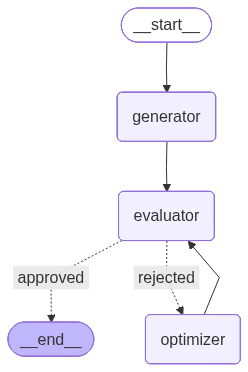

In [44]:
# Graph

graph = StateGraph(state_schema= PostState)

# Add nodes

graph.add_node("generator",generator)
graph.add_node("evaluator",evaluator)
graph.add_node("optimizer",optimizer)

# Add Edges

graph.add_edge(START, "generator")
graph.add_edge("generator", "evaluator")
    # Conditional edges
    # Here in 3rd param, pass a dictionary, that maps strings
    # (corresponding to each condition) to their respective
    # associated nodes(functions)
graph.add_conditional_edges("evaluator", check_condition,
                        {
                            "approved": END,
                            "rejected": "optimizer"
                        })
    # optimizer output edge
graph.add_edge("optimizer", "evaluator")

graph.add_edge("evaluator", END)

workflow = graph.compile()

workflow

In [46]:
topic = "LLMs for corporate growth"
init_state = {
    "topic" : topic ,
    "current_iteration": 1,
    "max_iterations": 5
}
final_state = workflow.invoke(init_state)
final_state

{'topic': 'LLMs for corporate growth',
 'generated_post': 'Here\'s a rewritten LinkedIn post with a professional tone, a touch of humor, and a reference to the corporate environment:\n\n"\'The coffee machine whisperer\' takes a backseat: How LLMs (Large Language Models) are cooking up corporate growth recipes. From automating dull tasks to predicting sales wins, AI is taking the reins. Who\'s really running the show now? #CorpGrowth #LLMs #AI"',
 'evaluation': 'approved',
 'feedback': 'The post effectively utilizes a bit of humor to engage readers while highlighting the benefits of LLMs in corporate growth. However, it could be more concise and directly address the impact of LLMs on corporate growth.',
 'current_iteration': 2,
 'max_iterations': 5}

In [47]:
print(final_state["generated_post"])

Here's a rewritten LinkedIn post with a professional tone, a touch of humor, and a reference to the corporate environment:

"'The coffee machine whisperer' takes a backseat: How LLMs (Large Language Models) are cooking up corporate growth recipes. From automating dull tasks to predicting sales wins, AI is taking the reins. Who's really running the show now? #CorpGrowth #LLMs #AI"
